In [272]:
# ticker_clean_auxiliary.py


import pandas as pd
import numpy as np
import datetime as dt
import os
import csv


def slice_date(date):
    day = date % 100
    month = date // 100 % 100
    year = date // 10000
    return (year, month, day)


def slice_min(Time):
    if np.isnan(Time):
        return(-1, -1, -1)
    else:
        Hour = Time // 10000000
        Min = Time // 100000 % 100
        Sec = Time // 1000 % 100
        return (int(Hour), int(Min), int(Sec))


def split_level(x, name):
    temp_table = x[name].str.split(',',expand=True)
    temp_table.iloc[:, 0] = temp_table.iloc[:, 0].apply(lambda x: x[1:])
    return temp_table.iloc[:, :10].astype(int)


def data_clean(data, trading_day):

    # clean data into same time range
    (Year, Month, Day) = slice_date(trading_day)
    time_start = dt.datetime(Year, Month, Day, 9, 15, 0)
    time_end = dt.datetime(Year, Month, Day, 15, 0, 0)
    time_range = pd.date_range(time_start, time_end, freq='1S')
    time_range2 = pd.date_range(time_start, time_end, freq='3S')
    time_col = data['Time'].values
    temp_dateTime = []
    for i in range(len(time_col)):
        H, M, S = slice_min(time_col[i])
        if H == -1:
            continue
        else:
            temp_dateTime.append(dt.datetime(Year, Month, Day, H, M, S))
    data.index = pd.DatetimeIndex(temp_dateTime)

    main_part_cols = ['High', 'Low', 'Close',
                      'TransactionNum', 'TransactionVol', 'TransactionAmount', 'TotalBidVol',
                      'TotalAskVol', 'WeightedAvgBidPrice', 'WeightedAvgAskPrice',
                      'HighLimit', 'LowLimit', 'AskPrice1', 'AskPrice2', 'AskPrice3',
                      'AskPrice4', 'AskPrice5', 'AskPrice6', 'AskPrice7', 'AskPrice8',
                      'AskPrice9', 'AskPrice10', 'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4',
                      'AskVol5', 'AskVol6', 'AskVol7', 'AskVol8', 'AskVol9', 'AskVol10',
                      'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5',
                      'BidPrice6', 'BidPrice7', 'BidPrice8', 'BidPrice9', 'BidPrice10',
                      'BidVol1', 'BidVol2', 'BidVol3', 'BidVol4', 'BidVol5', 'BidVol6',
                      'BidVol7', 'BidVol8', 'BidVol9', 'BidVol10']
    sub_cols = ['Status', 'PreClose', 'Open']

    # diminish the same data points at the same timestamps
    # When encountered mutiple row for the same time_index,
    # take mean on main part, take last on PreClose, TodayOpen, and Status
    data_main_part = data[main_part_cols].groupby(level=0).mean().astype(int)
    data_status = data[sub_cols].groupby(level=0).last()
    data_status.columns = ['Status', 'PreClose', 'TodayOpen']

    result = pd.DataFrame()
    result[data_main_part.columns] = data_main_part
    result[data_status.columns] = data_status 
    # result = result.reindex(time_range)
    # To avoid lossing info because of differnt sampling time point
    result = result.reindex(time_range).ffill().dropna()
    result = result.reindex(time_range2).ffill().dropna().astype(int)
    # create open col using close of last tick
    result['Open'] = result['Close'].shift(1).fillna(0).astype(int)
    # take difference on these three cumulated volume to get vols in last tick
    result[['TransactionNum', 'TransactionVol','TransactionAmount']] = result[['TransactionNum', 'TransactionVol','TransactionAmount']].diff(1).dropna()
    result = result.dropna().astype(int)
    UpThreshold = dt.datetime(Year, Month, Day, 9, 30, 0)
    DownThreshold = dt.datetime(Year, Month, Day, 11, 30, 0)
    UpThreshold2 = dt.datetime(Year, Month, Day, 13, 0, 0)
    result = result[((result.index > UpThreshold) & (result.index <= DownThreshold)) | (result.index > UpThreshold2)]
    if len(result) > 0:
        result['Open'].iloc[0] = result['TodayOpen'].iloc[0]
    result.name = UpThreshold
    return result

def bar_generator(data, freq='3S'):

    if len(data) == 0:
        return None
    else:
        function_dict = {'PreClose' :'first', 'TodayOpen' :'first', 'Close' :'last', 'Open' :'first', 'High' :'max', 
                         'Low' :'min', 'Status' :'last', 'AskPrice1' :'last', 'AskPrice2' :'last', 'AskPrice3' :'last', 
                         'AskPrice4' :'last', 'AskPrice5' :'last', 'AskPrice6' :'last', 'AskPrice7' :'last', 
                         'AskPrice8' :'last', 'AskPrice9' :'last', 'AskPrice10' :'last', 'BidPrice1' :'last', 
                         'BidPrice2' :'last', 'BidPrice3' :'last', 'BidPrice4' :'last', 'BidPrice5' :'last', 
                         'BidPrice6' :'last', 'BidPrice7' :'last', 'BidPrice8' :'last', 'BidPrice9' :'last', 
                         'BidPrice10' :'last', 'AskVol1' :'last', 'AskVol2' :'last', 'AskVol3' :'last', 
                         'AskVol4' :'last', 'AskVol5' :'last', 'AskVol6' :'last', 'AskVol7' :'last', 'AskVol8' :'last', 
                         'AskVol9' :'last', 'AskVol10' :'last', 'BidVol1' :'last', 'BidVol2' :'last', 'BidVol3' :'last', 
                         'BidVol4' :'last', 'BidVol5' :'last', 'BidVol6' :'last', 'BidVol7' :'last', 'BidVol8' :'last', 
                         'BidVol9' :'last', 'BidVol10' :'last', 'WeightedAvgBidPrice' :'last', 'WeightedAvgAskPrice' :'last', 
                         'TransactionNum' :'sum', 'TransactionVol' :'sum', 'TransactionAmount' :'sum', 'TotalAskVol' :'sum', 
                         'TotalBidVol' :'sum', 'HighLimit' :'last', 'LowLimit' :'last'}
        result = data.resample(freq, closed='right', label='right').agg(function_dict)
        result['Mid'] = result.apply(f, axis=1)
        result = result.ffill().bfill()
        Year, Month, Day = data.index[0].year, data.index[0].month, data.index[0].day
        UpThreshold = dt.datetime(Year, Month, Day, 9, 30, 0)
        DownThreshold = dt.datetime(Year, Month, Day, 11, 30, 0)
        UpThreshold2 = dt.datetime(Year, Month, Day, 13, 0, 0)
        stk_columns = ['Status', 'PreClose', 'TodayOpen', 'Open', 'High', 'Low', 'Close', 'Mid', 'TransactionNum',
                       'TransactionVol', 'TransactionAmount', 'TotalBidVol', 'TotalAskVol', 'WeightedAvgBidPrice', 
                       'WeightedAvgAskPrice', 'HighLimit', 'LowLimit', 'AskPrice1', 'AskPrice2', 'AskPrice3', 
                       'AskPrice4', 'AskPrice5', 'AskPrice6', 'AskPrice7', 'AskPrice8', 'AskPrice9', 'AskPrice10', 
                       'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4', 'AskVol5', 'AskVol6', 'AskVol7', 'AskVol8', 'AskVol9', 
                       'AskVol10', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'BidPrice6', 
                       'BidPrice7', 'BidPrice8', 'BidPrice9', 'BidPrice10', 'BidVol1', 'BidVol2', 'BidVol3', 
                       'BidVol4', 'BidVol5', 'BidVol6', 'BidVol7', 'BidVol8', 'BidVol9', 'BidVol10']
        result = result[((result.index > UpThreshold) & (result.index <= DownThreshold)) | (result.index > UpThreshold2)]
        result = result.loc[:, stk_columns]
        result.name = freq
        return result


def TargetGenerator(data, base_freq, future_period):

    base_freq_str = str(base_freq) + 'S'
    dataObjFreq = bar_generator(data, base_freq_str)
    num_shift = int(future_period / base_freq)
    close_shift = dataObjFreq['Close'].shift(-num_shift)
    numReturn = (close_shift - dataObjFreq['Close']) / dataObjFreq['Close'] 
    numReturn[~np.isfinite(numReturn)] = np.nan
    dataObjFreq['numReturn'] = numReturn

    return dataObjFreq


def TargerGeneratorReturn(data, future_period):

    base_freq_str = data.name
    freq = int(base_freq_str[:-1])
    num_shift = int(future_period / freq)
    result = pd.DataFrame()
    Mid_shift = data['Mid'].shift(-num_shift)
    MidReturn = (Mid_shift - data['Mid']) / (data['Mid'])
    MidReturn[~np.isfinite(MidReturn)] = np.nan
    result['MidReturn' + str(future_period)] = MidReturn
    return result


def TargetSeriesGenerate(data, rt_series=[15, 30, 60, 90, 300, 600, 900, 1500, 2400]):
    result = []
    for ti in rt_series:
        result.append(TargerGeneratorReturn(data, ti))
    target_all = pd.concat(result, axis=1)
    return target_all




In [301]:
f = lambda x: (x['AskPrice1'] + x['BidPrice1']) / 2 if x['AskPrice1'] > 0 and x['BidPrice1'] > 0 else np.nan    


In [273]:
data_01 = pd.HDFStore('F:\\tick_raw\\20180723.h5', 'r')

In [274]:
keys = data_01.keys()
result_less = []
for k in keys:
    result_less.append(len(data_01[k]))

In [275]:
len_np = np.array(result_less)
print(np.sort(len_np))

[   1    1    2 ... 4966 4975 4977]


In [321]:
test_01 = data_01[keys[lens_order[155]]]

In [322]:
test_01

,Time,Status,PreClose,Open,High,Low,Close,TransactionNum,TransactionVol,TransactionAmount,...,BidVol1,BidVol2,BidVol3,BidVol4,BidVol5,BidVol6,BidVol7,BidVol8,BidVol9,BidVol10
Time,,,,,,,,,,,,,,,,,,,,,
80000000,80000000,0,59300,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80000000,80000000,69,59300,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80000000,80000000,69,59300,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92504000,92504000,73,59300,0,0,0,0,0,0,0,...,12800,2000,18800,4000,27900,3000,10000,400,1700,0
92504000,92504000,73,59300,0,0,0,0,0,0,0,...,12800,2000,18800,4000,27900,3000,10000,400,1700,0
92504000,92504000,100,59300,0,0,0,0,0,0,0,...,12800,2000,18800,4000,27900,3000,10000,400,1700,0
92504000,92504000,100,59300,0,0,0,0,0,0,0,...,12800,2000,18800,4000,27900,3000,10000,400,1700,0
92902000,92902000,79,59300,0,0,0,0,0,0,0,...,12800,2000,18800,4000,27900,3000,10000,400,1700,0
92902000,92902000,79,59300,0,0,0,0,0,0,0,...,12800,2000,18800,4000,27900,3000,10000,400,1700,0


In [152]:
    data = test_01
    (Year, Month, Day) = slice_date(20180723)
    time_start = dt.datetime(Year, Month, Day, 9, 15, 0)
    time_end = dt.datetime(Year, Month, Day, 15, 0, 0)
    time_range = pd.date_range(time_start, time_end, freq='1S')
    time_range2 = pd.date_range(time_start, time_end, freq='3S')
    time_col = test_01['Time'].values
    temp_dateTime = []
    for i in range(len(time_col)):
        H, M, S = slice_min(time_col[i])
        if H == -1:
            continue
        else:
            temp_dateTime.append(dt.datetime(Year, Month, Day, H, M, S))
    data.index = pd.DatetimeIndex(temp_dateTime)

    main_part_cols = ['High', 'Low', 'Close',
                      'TransactionNum', 'TransactionVol', 'TransactionAmount', 'TotalBidVol',
                      'TotalAskVol', 'WeightedAvgBidPrice', 'WeightedAvgAskPrice',
                      'HighLimit', 'LowLimit', 'AskPrice1', 'AskPrice2', 'AskPrice3',
                      'AskPrice4', 'AskPrice5', 'AskPrice6', 'AskPrice7', 'AskPrice8',
                      'AskPrice9', 'AskPrice10', 'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4',
                      'AskVol5', 'AskVol6', 'AskVol7', 'AskVol8', 'AskVol9', 'AskVol10',
                      'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5',
                      'BidPrice6', 'BidPrice7', 'BidPrice8', 'BidPrice9', 'BidPrice10',
                      'BidVol1', 'BidVol2', 'BidVol3', 'BidVol4', 'BidVol5', 'BidVol6',
                      'BidVol7', 'BidVol8', 'BidVol9', 'BidVol10']
    sub_cols = ['Status', 'PreClose', 'Open']

    # diminish the same data points at the same timestamps
    # When encountered mutiple row for the same time_index,
    # take mean on main part, take last on PreClose, TodayOpen, and Status
    data_main_part = data[main_part_cols].groupby(level=0).mean().astype(int)
    data_status = data[sub_cols].groupby(level=0).last()
    data_status.columns = ['Status', 'PreClose', 'PreOpen']

    result = pd.DataFrame()
    result[data_main_part.columns] = data_main_part
    result[data_status.columns] = data_status 
#     result = result.reindex(time_range)
    result = result.reindex(time_range).ffill().dropna()
    result = result.reindex(time_range2).ffill().dropna().astype(int)
#     # create open col using close of last tick
    result['Open'] = result['Close'].shift(1).fillna(0).astype(int)
    # take difference on these three cumulated volume to get vols in last tick
    result[['TransactionNum', 'TransactionVol','TransactionAmount']] = result[['TransactionNum', 'TransactionVol','TransactionAmount']].diff(1).dropna()
    result = result.dropna().astype(int)
    UpThreshold = dt.datetime(Year, Month, Day, 9, 30, 0)
    DownThreshold = dt.datetime(Year, Month, Day, 11, 30, 0)
    UpThreshold2 = dt.datetime(Year, Month, Day, 13, 0, 0)
    result = result[((result.index > UpThreshold) & (result.index <= DownThreshold)) | (result.index > UpThreshold2)]
    result.name = UpThreshold

In [323]:
result = data_clean(test_01, 20180723)

In [320]:
result

,High,Low,Close,TransactionNum,TransactionVol,TransactionAmount,TotalBidVol,TotalAskVol,WeightedAvgBidPrice,WeightedAvgAskPrice,...,BidVol5,BidVol6,BidVol7,BidVol8,BidVol9,BidVol10,Status,PreClose,TodayOpen,Open
2018-07-23 09:30:03,74100,74100,74100,0,0,0,66200,112241,70870,75200,...,8000,8000,2100,18900,4200,500,79,72700,74100,74100
2018-07-23 09:30:06,74100,74100,74100,0,0,0,113000,144659,71020,74940,...,10000,1100,18100,8000,8000,23100,79,72700,74100,74100
2018-07-23 09:30:09,74100,74100,74100,0,0,0,113000,144659,71020,74940,...,10000,1100,18100,8000,8000,23100,79,72700,74100,74100
2018-07-23 09:30:12,74100,74100,74100,0,0,0,113000,144659,71020,74940,...,10000,1100,18100,8000,8000,23100,79,72700,74100,74100
2018-07-23 09:30:15,74100,72800,72800,1,2000,14560,111000,144659,70990,74940,...,10000,1100,18100,8000,8000,23100,79,72700,74100,74100
2018-07-23 09:30:18,74100,72800,72800,0,0,0,111000,154659,70990,74870,...,10000,1100,18100,8000,8000,23100,79,72700,74100,72800
2018-07-23 09:30:21,74100,72800,72800,0,0,0,111000,154659,70990,74870,...,10000,1100,18100,8000,8000,23100,79,72700,74100,72800
2018-07-23 09:30:24,74100,72800,72800,0,0,0,111000,154659,70990,74870,...,10000,1100,18100,8000,8000,23100,79,72700,74100,72800
2018-07-23 09:30:27,74100,72800,72800,0,0,0,111000,149659,70990,74890,...,10000,1100,18100,8000,8000,23100,79,72700,74100,72800
2018-07-23 09:30:30,74100,72800,72800,0,0,0,111000,149659,70990,74890,...,10000,1100,18100,8000,8000,23100,79,72700,74100,72800


In [302]:
result_bar = bar_generator(result)

In [303]:
result_bar

,Status,PreClose,TodayOpen,Open,High,Low,Close,Mid,TransactionNum,TransactionVol,...,BidVol1,BidVol2,BidVol3,BidVol4,BidVol5,BidVol6,BidVol7,BidVol8,BidVol9,BidVol10
2018-07-23 09:30:03,79.0,78600.0,78300.0,78300.0,78400.0,78300.0,78400.0,77700.0,2,42300,...,300.0,3000.0,400.0,200.0,500.0,1000.0,500.0,200.0,1000.0,3000.0
2018-07-23 09:30:06,79.0,78600.0,78300.0,78400.0,78400.0,78300.0,78400.0,77600.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:09,79.0,78600.0,78300.0,78400.0,78400.0,78300.0,78400.0,77600.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:12,79.0,78600.0,78300.0,78400.0,78400.0,78300.0,78400.0,77600.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:15,79.0,78600.0,78300.0,78400.0,78400.0,78300.0,78400.0,77600.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:18,79.0,78600.0,78300.0,78400.0,78400.0,78300.0,78400.0,77600.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:21,79.0,78600.0,78300.0,78400.0,78400.0,78100.0,78300.0,77700.0,6,6300,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:24,79.0,78600.0,78300.0,78300.0,78400.0,78100.0,78300.0,77700.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:27,79.0,78600.0,78300.0,78300.0,78400.0,78100.0,78300.0,77700.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0
2018-07-23 09:30:30,79.0,78600.0,78300.0,78300.0,78400.0,78100.0,78300.0,77700.0,0,0,...,300.0,23000.0,400.0,900.0,1500.0,3000.0,500.0,200.0,1000.0,6000.0


In [304]:
result_bar.astype(int)

,Status,PreClose,TodayOpen,Open,High,Low,Close,Mid,TransactionNum,TransactionVol,...,BidVol1,BidVol2,BidVol3,BidVol4,BidVol5,BidVol6,BidVol7,BidVol8,BidVol9,BidVol10
2018-07-23 09:30:03,79,78600,78300,78300,78400,78300,78400,77700,2,42300,...,300,3000,400,200,500,1000,500,200,1000,3000
2018-07-23 09:30:06,79,78600,78300,78400,78400,78300,78400,77600,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:09,79,78600,78300,78400,78400,78300,78400,77600,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:12,79,78600,78300,78400,78400,78300,78400,77600,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:15,79,78600,78300,78400,78400,78300,78400,77600,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:18,79,78600,78300,78400,78400,78300,78400,77600,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:21,79,78600,78300,78400,78400,78100,78300,77700,6,6300,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:24,79,78600,78300,78300,78400,78100,78300,77700,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:27,79,78600,78300,78300,78400,78100,78300,77700,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000
2018-07-23 09:30:30,79,78600,78300,78300,78400,78100,78300,77700,0,0,...,300,23000,400,900,1500,3000,500,200,1000,6000


In [261]:
result[result.columns] = 0

In [262]:
result

,High,Low,Close,TransactionNum,TransactionVol,TransactionAmount,TotalBidVol,TotalAskVol,WeightedAvgBidPrice,WeightedAvgAskPrice,...,BidVol5,BidVol6,BidVol7,BidVol8,BidVol9,BidVol10,Status,PreClose,TodayOpen,Open


In [263]:
test_01.columns

Index(['Time', 'Status', 'PreClose', 'Open', 'High', 'Low', 'Close',
       'TransactionNum', 'TransactionVol', 'TransactionAmount', 'TotalBidVol',
       'TotalAskVol', 'WeightedAvgBidPrice', 'WeightedAvgAskPrice',
       'HighLimit', 'LowLimit', 'AskPrice1', 'AskPrice2', 'AskPrice3',
       'AskPrice4', 'AskPrice5', 'AskPrice6', 'AskPrice7', 'AskPrice8',
       'AskPrice9', 'AskPrice10', 'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4',
       'AskVol5', 'AskVol6', 'AskVol7', 'AskVol8', 'AskVol9', 'AskVol10',
       'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5',
       'BidPrice6', 'BidPrice7', 'BidPrice8', 'BidPrice9', 'BidPrice10',
       'BidVol1', 'BidVol2', 'BidVol3', 'BidVol4', 'BidVol5', 'BidVol6',
       'BidVol7', 'BidVol8', 'BidVol9', 'BidVol10'],
      dtype='object')

In [264]:
result.columns

Index(['High', 'Low', 'Close', 'TransactionNum', 'TransactionVol',
       'TransactionAmount', 'TotalBidVol', 'TotalAskVol',
       'WeightedAvgBidPrice', 'WeightedAvgAskPrice', 'HighLimit', 'LowLimit',
       'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5',
       'AskPrice6', 'AskPrice7', 'AskPrice8', 'AskPrice9', 'AskPrice10',
       'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4', 'AskVol5', 'AskVol6',
       'AskVol7', 'AskVol8', 'AskVol9', 'AskVol10', 'BidPrice1', 'BidPrice2',
       'BidPrice3', 'BidPrice4', 'BidPrice5', 'BidPrice6', 'BidPrice7',
       'BidPrice8', 'BidPrice9', 'BidPrice10', 'BidVol1', 'BidVol2', 'BidVol3',
       'BidVol4', 'BidVol5', 'BidVol6', 'BidVol7', 'BidVol8', 'BidVol9',
       'BidVol10', 'Status', 'PreClose', 'TodayOpen', 'Open'],
      dtype='object')

In [265]:
len(result)

0

In [267]:
result[['Status', 'PreClose', 'TodayOpen', 'Open', 'High', 'Low', 'Close', 'TransactionNum',
                   'TransactionVol', 'TransactionAmount', 'TotalBidVol', 'TotalAskVol', 'WeightedAvgBidPrice', 
                   'WeightedAvgAskPrice', 'HighLimit', 'LowLimit', 'AskPrice1', 'AskPrice2', 'AskPrice3', 
                   'AskPrice4', 'AskPrice5', 'AskPrice6', 'AskPrice7', 'AskPrice8', 'AskPrice9', 'AskPrice10', 
                   'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4', 'AskVol5', 'AskVol6', 'AskVol7', 'AskVol8', 'AskVol9', 
                   'AskVol10', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'BidPrice6', 
                   'BidPrice7', 'BidPrice8', 'BidPrice9', 'BidPrice10', 'BidVol1', 'BidVol2', 'BidVol3', 
                   'BidVol4', 'BidVol5', 'BidVol6', 'BidVol7', 'BidVol8', 'BidVol9', 'BidVol10']]

,Status,PreClose,TodayOpen,Open,High,Low,Close,TransactionNum,TransactionVol,TransactionAmount,...,BidVol1,BidVol2,BidVol3,BidVol4,BidVol5,BidVol6,BidVol7,BidVol8,BidVol9,BidVol10


In [268]:
len(['Status', 'PreClose', 'TodayOpen', 'Open', 'High', 'Low', 'Close', 'Mid', 'TransactionNum',
                   'TransactionVol', 'TransactionAmount', 'TotalBidVol', 'TotalAskVol', 'WeightedAvgBidPrice', 
                   'WeightedAvgAskPrice', 'HighLimit', 'LowLimit', 'AskPrice1', 'AskPrice2', 'AskPrice3', 
                   'AskPrice4', 'AskPrice5', 'AskPrice6', 'AskPrice7', 'AskPrice8', 'AskPrice9', 'AskPrice10', 
                   'AskVol1', 'AskVol2', 'AskVol3', 'AskVol4', 'AskVol5', 'AskVol6', 'AskVol7', 'AskVol8', 'AskVol9', 
                   'AskVol10', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'BidPrice6', 
                   'BidPrice7', 'BidPrice8', 'BidPrice9', 'BidPrice10', 'BidVol1', 'BidVol2', 'BidVol3', 
                   'BidVol4', 'BidVol5', 'BidVol6', 'BidVol7', 'BidVol8', 'BidVol9', 'BidVol10'])

57

In [306]:
x = None
if not x:
    print(111)

111


In [307]:
x = '20170802.h5'

In [310]:
int(x[:-3])

20170802

In [311]:
h5_path = 'F:/tick_raw'

In [312]:
os.listdir(h5_path)

['20180601.h5',
 '20180604.h5',
 '20180605.h5',
 '20180606.h5',
 '20180607.h5',
 '20180608.h5',
 '20180611.h5',
 '20180612.h5',
 '20180613.h5',
 '20180614.h5',
 '20180615.h5',
 '20180619.h5',
 '20180620.h5',
 '20180621.h5',
 '20180622.h5',
 '20180625.h5',
 '20180626.h5',
 '20180627.h5',
 '20180628.h5',
 '20180629.h5',
 '20180702.h5',
 '20180703.h5',
 '20180704.h5',
 '20180705.h5',
 '20180706.h5',
 '20180709.h5',
 '20180710.h5',
 '20180711.h5',
 '20180712.h5',
 '20180713.h5',
 '20180716.h5',
 '20180717.h5',
 '20180718.h5',
 '20180720.h5',
 '20180723.h5']

In [328]:
if result is None:
    print(111)
elif result is not None:
    print(222)

222


In [334]:
d = 'F:/targets_bar/20180629.h5'
d2 = 'F:/tick_bar/20180629.h5'

In [335]:
hl = pd.HDFStore(d)
hl2 = pd.HDFStore(d2)

In [336]:
hl['000001.SZ']

,MidReturn15,MidReturn30,MidReturn60,MidReturn90,MidReturn300,MidReturn600,MidReturn900,MidReturn1500,MidReturn2400
2018-06-29 09:30:03,-0.001108,0.000000,-0.001108,-0.001108,-0.002216,-0.005540,-0.002216,-0.003324,-0.002216
2018-06-29 09:30:06,-0.001107,-0.001107,-0.002214,-0.002214,-0.004427,-0.006641,-0.003320,-0.005534,-0.003320
2018-06-29 09:30:09,0.000000,0.000000,-0.001108,-0.001108,-0.003324,-0.005540,-0.002216,-0.004432,-0.002216
2018-06-29 09:30:12,0.000000,-0.001108,-0.001108,-0.001108,-0.003324,-0.005540,-0.002216,-0.004432,-0.002216
2018-06-29 09:30:15,0.001109,0.000000,0.000000,0.000000,-0.001109,-0.004437,-0.001109,-0.003328,-0.002219
2018-06-29 09:30:18,0.001109,0.000000,0.000000,0.000000,-0.002219,-0.004437,-0.001109,-0.002219,-0.002219
2018-06-29 09:30:21,0.000000,-0.001108,-0.001108,-0.001108,-0.003324,-0.005540,-0.002216,-0.003324,-0.003324
2018-06-29 09:30:24,0.000000,-0.001108,-0.001108,-0.001108,-0.003324,-0.005540,-0.002216,-0.003324,-0.003324
2018-06-29 09:30:27,-0.001108,-0.001108,-0.001108,-0.001108,-0.003324,-0.005540,-0.002216,-0.003324,-0.003324
2018-06-29 09:30:30,-0.001108,-0.001108,-0.001108,-0.001108,-0.003324,-0.005540,-0.002216,-0.003324,-0.003324


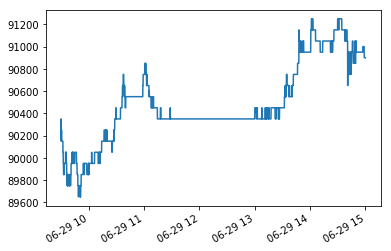

In [338]:
hl2['000001.SZ'].Mid.plot()

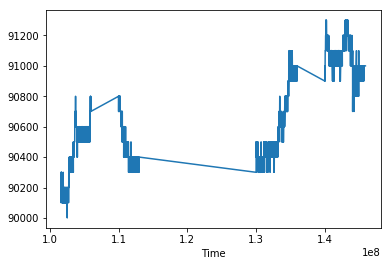

In [344]:
d3 = 'F:/tick_raw/20180629.h5'
hl3 = pd.HDFStore(d3)
hl3['000001.SZ'].Close.iloc[1000:].plot()

In [533]:
d4 = 'F:/transaction_raw/20180702.h5'
hl4 = pd.HDFStore(d4, 'r')
g = hl4['000001.SZ'].copy()


In [534]:
g

,Time,Index,BSFlag,Price,Volume,Turnover,AskOrder,BidOrder,OrderKind,FunctionCode
74458,91502010,54214,32,0,2000,0,33986,0,0,67
123580,91505330,71883,32,0,100,0,0,32131,0,67
123586,91505340,71905,32,0,100,0,71900,0,0,67
123587,91505340,71906,32,0,100,0,71903,0,0,67
123588,91505340,71907,32,0,100,0,71902,0,0,67
123589,91505340,71909,32,0,100,0,70077,0,0,67
123616,91505390,72057,32,0,100,0,72046,0,0,67
123617,91505390,72058,32,0,100,0,72048,0,0,67
123618,91505390,72059,32,0,100,0,72050,0,0,67
123619,91505390,72061,32,0,100,0,72051,0,0,67


In [535]:
chr(32)

' '

In [477]:
%%timeit
new_df = g[g.columns.difference(['Time'])]

1.57 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [472]:
%%timeit
new_df = g.loc[:, g.columns != 'b']

1.2 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [476]:
%%timeit
new_df = g.drop('Time', axis=1)

1.23 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [345]:
d3 = 'F:/order_raw/20180629.h5'
hl3 = pd.HDFStore(d3)

In [349]:
z = hl3['000001.SZ'].copy()
z

,Time,Order,Price,Volume,Amount,OrderKind,FunctionCode
2623,91500010,318,95000,100,950,48,66
2675,91500010,378,98000,1000,9800,48,83
2680,91500010,384,80300,200,1606,48,66
2856,91500030,563,97000,300,2910,48,83
2876,91500030,583,87100,3000,26130,48,66
2879,91500030,586,91900,3000,27570,48,83
2981,91500040,691,86100,3000,25830,48,66
3031,91500040,744,87500,100,875,48,66
3163,91500050,880,93700,600,5622,48,83
4247,91500050,927,87100,1200,10452,48,66


In [369]:
z.Time.iloc[-3] % 1000

150

In [374]:
time = z.Time.iloc[-6]
hour = time // 10000000
minute = time // 100000 % 100
sec =  time // 1000 % 100
ms = time  % 1000 * 1000
print(hour, minute, sec, ms)

14 59 55 130000


In [382]:
from datetime import datetime
def split_date(date):
    day = date % 100
    month = date // 100 % 100
    year = date // 10000
    return (year, month, day)

In [398]:
def split_time_ms(day, time):
    hour = time // 10000000
    minute = time // 100000 % 100
    sec =  time // 1000 % 100
#     ms = time  % 1000 * 1000
    return datetime(*split_date(day), hour, minute, sec)
v_time_split = np.vectorize(split_time_ms)

In [399]:
tix = v_time_split(20180702, z.Time)

In [478]:
tix

array([datetime.datetime(2018, 7, 2, 9, 15),
       datetime.datetime(2018, 7, 2, 9, 15),
       datetime.datetime(2018, 7, 2, 9, 15), ...,
       datetime.datetime(2018, 7, 2, 14, 59, 58),
       datetime.datetime(2018, 7, 2, 14, 59, 59),
       datetime.datetime(2018, 7, 2, 14, 59, 59)], dtype=object)

In [479]:
z.index = tix

In [481]:
z.index

DatetimeIndex(['2018-07-02 09:15:00', '2018-07-02 09:15:00',
               '2018-07-02 09:15:00', '2018-07-02 09:15:00',
               '2018-07-02 09:15:00', '2018-07-02 09:15:00',
               '2018-07-02 09:15:00', '2018-07-02 09:15:00',
               '2018-07-02 09:15:00', '2018-07-02 09:15:00',
               ...
               '2018-07-02 14:59:53', '2018-07-02 14:59:53',
               '2018-07-02 14:59:54', '2018-07-02 14:59:54',
               '2018-07-02 14:59:55', '2018-07-02 14:59:57',
               '2018-07-02 14:59:57', '2018-07-02 14:59:58',
               '2018-07-02 14:59:59', '2018-07-02 14:59:59'],
              dtype='datetime64[ns]', length=42795, freq=None)

In [408]:
vol = z.Volume

In [428]:
v = vol.loc['201807020935':'201807020936']
v

2018-07-02 09:35:00      2900
2018-07-02 09:35:00       100
2018-07-02 09:35:01       500
2018-07-02 09:35:02      2600
2018-07-02 09:35:02       100
2018-07-02 09:35:03       200
2018-07-02 09:35:03      1000
2018-07-02 09:35:03     12000
2018-07-02 09:35:03       300
2018-07-02 09:35:03     10700
2018-07-02 09:35:03      1000
2018-07-02 09:35:04       600
2018-07-02 09:35:04      2000
2018-07-02 09:35:04      5000
2018-07-02 09:35:05      2000
2018-07-02 09:35:05       100
2018-07-02 09:35:05      7000
2018-07-02 09:35:06      3700
2018-07-02 09:35:06       100
2018-07-02 09:35:06      1000
2018-07-02 09:35:06       900
2018-07-02 09:35:06       100
2018-07-02 09:35:06       600
2018-07-02 09:35:07      2000
2018-07-02 09:35:07       300
2018-07-02 09:35:07       200
2018-07-02 09:35:07      1000
2018-07-02 09:35:07       500
2018-07-02 09:35:07      1000
2018-07-02 09:35:07      1000
                        ...  
2018-07-02 09:36:54       100
2018-07-02 09:36:54      9300
2018-07-02

In [454]:
def f(x):
    if x is not None:
        l = len(x)
        result = x.sum() / l if l > 0 else 0
        return result
    else:
        0

In [458]:
x = v.rolling('3S', closed='right').apply(f, raw=True)
x

2018-07-02 09:35:00     2900.000000
2018-07-02 09:35:00     1500.000000
2018-07-02 09:35:01     1166.666667
2018-07-02 09:35:02     1525.000000
2018-07-02 09:35:02     1240.000000
2018-07-02 09:35:03      850.000000
2018-07-02 09:35:03      880.000000
2018-07-02 09:35:03     2733.333333
2018-07-02 09:35:03     2385.714286
2018-07-02 09:35:03     3425.000000
2018-07-02 09:35:03     3155.555556
2018-07-02 09:35:04     3166.666667
2018-07-02 09:35:04     3050.000000
2018-07-02 09:35:04     3227.272727
2018-07-02 09:35:05     3480.000000
2018-07-02 09:35:05     3172.727273
2018-07-02 09:35:05     3491.666667
2018-07-02 09:35:06     2914.285714
2018-07-02 09:35:06     2562.500000
2018-07-02 09:35:06     2388.888889
2018-07-02 09:35:06     2240.000000
2018-07-02 09:35:06     2045.454545
2018-07-02 09:35:06     1925.000000
2018-07-02 09:35:07     1750.000000
2018-07-02 09:35:07     1618.181818
2018-07-02 09:35:07     1500.000000
2018-07-02 09:35:07     1461.538462
2018-07-02 09:35:07     1392

In [457]:
x[~x.index.duplicated(keep='first')]

2018-07-02 09:35:00             NaN
2018-07-02 09:35:01     1500.000000
2018-07-02 09:35:02     1166.666667
2018-07-02 09:35:03     1240.000000
2018-07-02 09:35:04     3155.555556
2018-07-02 09:35:05     3227.272727
2018-07-02 09:35:06     3491.666667
2018-07-02 09:35:07     1925.000000
2018-07-02 09:35:08     1294.117647
2018-07-02 09:35:09     2971.434783
2018-07-02 09:35:10     3188.826087
2018-07-02 09:35:11     3133.720000
2018-07-02 09:35:12     1554.545455
2018-07-02 09:35:13     1561.111111
2018-07-02 09:35:14     2200.000000
2018-07-02 09:35:15     4253.333333
2018-07-02 09:35:16     3542.857143
2018-07-02 09:35:17     3515.000000
2018-07-02 09:35:18     1833.333333
2018-07-02 09:35:19     1362.500000
2018-07-02 09:35:20     1064.285714
2018-07-02 09:35:21      772.727273
2018-07-02 09:35:22      740.000000
2018-07-02 09:35:23     1570.000000
2018-07-02 09:35:24     1483.333333
2018-07-02 09:35:25     2966.666667
2018-07-02 09:35:26     6507.142857
2018-07-02 09:35:27     6846

In [440]:
x[~x.index.duplicated(keep='first')]

2018-07-02 09:35:00         NaN
2018-07-02 09:35:01      3000.0
2018-07-02 09:35:02      3500.0
2018-07-02 09:35:03      6200.0
2018-07-02 09:35:04     28400.0
2018-07-02 09:35:05     35500.0
2018-07-02 09:35:06     41900.0
2018-07-02 09:35:07     23100.0
2018-07-02 09:35:08     22000.0
2018-07-02 09:35:09     68343.0
2018-07-02 09:35:10     73343.0
2018-07-02 09:35:11     78343.0
2018-07-02 09:35:12     34200.0
2018-07-02 09:35:13     28100.0
2018-07-02 09:35:14     30800.0
2018-07-02 09:35:15     63800.0
2018-07-02 09:35:16     74400.0
2018-07-02 09:35:17     70300.0
2018-07-02 09:35:18     33000.0
2018-07-02 09:35:19     21800.0
2018-07-02 09:35:20     14900.0
2018-07-02 09:35:21      8500.0
2018-07-02 09:35:22      7400.0
2018-07-02 09:35:23     15700.0
2018-07-02 09:35:24     17800.0
2018-07-02 09:35:25     35600.0
2018-07-02 09:35:26     91100.0
2018-07-02 09:35:27    102700.0
2018-07-02 09:35:28     84000.0
2018-07-02 09:35:29     24200.0
                         ...   
2018-07-

In [509]:
x[x.index.hour * 100 + x.index.minute > 935]

2018-07-02 09:36:00     6085.714286
2018-07-02 09:36:00     5337.500000
2018-07-02 09:36:00     4811.111111
2018-07-02 09:36:00     4340.000000
2018-07-02 09:36:00     3972.727273
2018-07-02 09:36:00     3650.000000
2018-07-02 09:36:00     3423.076923
2018-07-02 09:36:00     3192.857143
2018-07-02 09:36:00     2986.666667
2018-07-02 09:36:00     2918.750000
2018-07-02 09:36:00     2870.588235
2018-07-02 09:36:00     2744.444444
2018-07-02 09:36:00     2626.315789
2018-07-02 09:36:00     2620.000000
2018-07-02 09:36:01     1563.157895
2018-07-02 09:36:01     1810.000000
2018-07-02 09:36:01     1747.619048
2018-07-02 09:36:01     1713.636364
2018-07-02 09:36:01     1682.608696
2018-07-02 09:36:01     1704.166667
2018-07-02 09:36:01     1680.000000
2018-07-02 09:36:01     1700.000000
2018-07-02 09:36:01     1707.407407
2018-07-02 09:36:01     1842.857143
2018-07-02 09:36:01     2468.965517
2018-07-02 09:36:01     2390.000000
2018-07-02 09:36:01     2348.387097
2018-07-02 09:36:01     2321

In [410]:
df = pd.DataFrame({'B': [0, 1, 2, 3, 4]},
                  index = [pd.Timestamp('20130101 09:00:00'),
              			   pd.Timestamp('20130101 09:00:02'),
			               pd.Timestamp('20130101 09:00:03'),
			               pd.Timestamp('20130101 09:00:05'),
			               pd.Timestamp('20130101 09:00:06')])

In [411]:
df

,B
2013-01-01 09:00:00,0
2013-01-01 09:00:02,1
2013-01-01 09:00:03,2
2013-01-01 09:00:05,3
2013-01-01 09:00:06,4


In [419]:
df = pd.DataFrame({'B': [0, 1, 2, 3, 4, 5, 6]},
                  index = [pd.Timestamp('20130101 09:00:00'),
                  		   pd.Timestamp('20130101 09:00:01'),
              			   pd.Timestamp('20130101 09:00:02'),
			               pd.Timestamp('20130101 09:00:03'),
                           pd.Timestamp('20130101 09:00:04'),
			               pd.Timestamp('20130101 09:00:05'),
			               pd.Timestamp('20130101 09:00:06')])

In [420]:
df

,B
2013-01-01 09:00:00,0
2013-01-01 09:00:01,1
2013-01-01 09:00:02,2
2013-01-01 09:00:03,3
2013-01-01 09:00:04,4
2013-01-01 09:00:05,5
2013-01-01 09:00:06,6


In [421]:
df.rolling('3S', closed='left').sum()

,B
2013-01-01 09:00:00,NaN
2013-01-01 09:00:01,0.0
2013-01-01 09:00:02,1.0
2013-01-01 09:00:03,3.0
2013-01-01 09:00:04,6.0
2013-01-01 09:00:05,9.0
2013-01-01 09:00:06,12.0


In [433]:
x = [  200,
 1000,
12000,
  300,
10700,
 1000,
  600,
 2000,
 5000,
 2000,
  100,
 7000]

In [434]:
sum(x)

41900

In [500]:
data = pd.HDFStore('F:/order_concated/order_concated.h5')

In [501]:
keys = data.keys()

In [502]:
keys

['/000001.SZ',
 '/000002.SZ',
 '/000004.SZ',
 '/000005.SZ',
 '/000006.SZ',
 '/000007.SZ',
 '/000008.SZ',
 '/000009.SZ',
 '/000010.SZ',
 '/000011.SZ',
 '/000012.SZ',
 '/000014.SZ',
 '/000016.SZ',
 '/000017.SZ',
 '/000018.SZ',
 '/000019.SZ',
 '/000020.SZ',
 '/000021.SZ',
 '/000023.SZ',
 '/000025.SZ',
 '/000026.SZ',
 '/000027.SZ',
 '/000028.SZ',
 '/000030.SZ',
 '/000031.SZ',
 '/000032.SZ',
 '/000034.SZ',
 '/000036.SZ',
 '/000037.SZ',
 '/000039.SZ',
 '/000040.SZ',
 '/000043.SZ',
 '/000045.SZ',
 '/000046.SZ',
 '/000049.SZ',
 '/000050.SZ',
 '/000055.SZ',
 '/000056.SZ',
 '/000058.SZ',
 '/000059.SZ',
 '/000060.SZ',
 '/000061.SZ',
 '/000062.SZ',
 '/000065.SZ',
 '/000066.SZ',
 '/000068.SZ',
 '/000069.SZ',
 '/000070.SZ',
 '/000078.SZ',
 '/000088.SZ',
 '/000089.SZ',
 '/000090.SZ',
 '/000096.SZ',
 '/000099.SZ',
 '/000100.SZ',
 '/000150.SZ',
 '/000151.SZ',
 '/000153.SZ',
 '/000155.SZ',
 '/000157.SZ',
 '/000159.SZ',
 '/000166.SZ',
 '/000301.SZ',
 '/000333.SZ',
 '/000338.SZ',
 '/000400.SZ',
 '/000401.

In [510]:
zc = data[keys[0]]

In [512]:
time_vector = zc.index.hour * 100 + zc.index.minute

In [516]:
sel = (time_vector >= 935) & (time_vector <= 1457)
zc.loc[sel, :]

,Order,Price,Volume,Amount,OrderKind,FunctionCode
2018-06-01 09:35:00,796091,100800,10000,100800,48,66
2018-06-01 09:35:00,796095,100100,2000,20020,48,66
2018-06-01 09:35:00,796117,100700,500,5035,48,66
2018-06-01 09:35:00,796145,100600,500,5030,48,66
2018-06-01 09:35:00,796323,100700,5700,57399,48,66
2018-06-01 09:35:00,796344,100700,2600,26182,48,66
2018-06-01 09:35:00,796430,100900,19400,195746,48,66
2018-06-01 09:35:00,796494,100700,100000,1007000,48,66
2018-06-01 09:35:00,796861,100700,7100,71497,48,83
2018-06-01 09:35:00,797021,100600,200,2012,48,66


In [492]:
data.select('000001.SZ', "index>=20180601 & index<=20180606 & columns=['Open', 'High', 'Low', 'Close']")

,Open,High,Low,Close
2018-06-01 09:30:03,101500.0,101500.0,101300.0,101300.0
2018-06-01 09:30:06,101300.0,101500.0,101300.0,101300.0
2018-06-01 09:30:09,101300.0,101500.0,101300.0,101300.0
2018-06-01 09:30:12,101300.0,101500.0,101200.0,101200.0
2018-06-01 09:30:15,101200.0,101500.0,101200.0,101200.0
2018-06-01 09:30:18,101200.0,101500.0,101200.0,101300.0
2018-06-01 09:30:21,101300.0,101500.0,101200.0,101200.0
2018-06-01 09:30:24,101200.0,101500.0,101100.0,101200.0
2018-06-01 09:30:27,101200.0,101500.0,101100.0,101200.0
2018-06-01 09:30:30,101200.0,101500.0,101100.0,101200.0


In [499]:
data.close()

In [525]:
data.close()
data = pd.HDFStore('F:/targets_concated/targets_concated.h5', 'r')

In [530]:
data['000002.SZ']

,MidReturn15,MidReturn30,MidReturn60,MidReturn90,MidReturn300,MidReturn600,MidReturn900,MidReturn1500,MidReturn2400
2018-06-01 09:30:03,0.000592,0.001381,0.003946,0.004340,0.003156,0.011048,0.022292,0.020911,0.029592
2018-06-01 09:30:06,0.000789,0.001775,0.004537,0.003551,0.005129,0.011442,0.022490,0.020517,0.028013
2018-06-01 09:30:09,-0.000197,0.002563,0.003352,0.003352,0.003943,0.011238,0.022871,0.019913,0.027405
2018-06-01 09:30:12,-0.000394,0.001577,0.003548,0.002760,0.004337,0.011236,0.021683,0.019712,0.027794
2018-06-01 09:30:15,0.000000,0.001578,0.003550,0.003155,0.005127,0.012226,0.022875,0.020114,0.028791
2018-06-01 09:30:18,0.000789,0.004140,0.002760,0.002957,0.005718,0.012224,0.022674,0.020308,0.027997
2018-06-01 09:30:21,0.000986,0.003745,0.002365,0.002760,0.005914,0.012616,0.023260,0.020106,0.027597
2018-06-01 09:30:24,0.002761,0.003155,0.003944,0.003944,0.006310,0.013410,0.023072,0.020509,0.028791
2018-06-01 09:30:27,0.001972,0.003155,0.003944,0.003944,0.006310,0.014396,0.023861,0.020114,0.028397
2018-06-01 09:30:30,0.001578,0.004141,0.003550,0.002761,0.006705,0.014198,0.022481,0.020114,0.028791


In [521]:
72000 / 4800

15.0